In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# train, validation 이미지 데이터셋 경로 설정 
rootPath = '.\\Kaggle_dataanalysis\\cat-and-dog'

train_dir = os.path.join(rootPath, 'train')
validation_dir = os.path.join(rootPath, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort() # 파일명을 오름차순으로 정렬 
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort() # 파일명을 오름차순으로 정렬 
print(train_dog_fnames[:10])

['cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg', 'dog.107.jpg']


In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 400
total validation dog images: 400


아래에 다음과 같은 옵션을 설정해줘서 해당 데이터 전처리를 하려고 한다. 

이런 전처리 과정을 돕기 위해 케라스는 ImageDataGenerator 클래스를 사용한다. 

● rotation_range: 이미지 회전 범위 (degrees)
    
● width_shift, height_shift: 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
    
● rescale: 원본 영상은 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높다.
    
  (통상적인 learning rate를 사용할 경우). 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜준다.   
   이는 다른 전처리 과정에 앞서 가장 먼저 적용됨
    
● shear_range: 임의 전단 변환 (shearing transformation) 범위
    
● zoom_range: 임의 확대/축소 범위
    
● horizontal_flip: True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집는다.
    
   원본 이미지에 수평 비대칭성이 없을 때 효과적임. 즉, 뒤집어도 자연스러울 때 사용하면 좋음
    
● fill_mode 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식
    

In [5]:

imageGenerator = ImageDataGenerator(rescale=1./255, validation_split=.1) 


2) Data spliting

flow_from_directory함수를 사용해서 이미지 데이터들이 들어있는 directory 자체를 불러와서 
training set과 validation set을 나눠준다.

target_size option으로 읽어올 이미지의 크기를 정해주는데 우리는 64*64 사이즈로 읽어온다. 

subset은 위에서 validation_split으로 설정한 trainig과 validation의 비율만큼 이미지를 가지고 온다.

In [6]:
# ImageDataGenerator에서   validation_split=.1  을 설정해놓았음    
# validation 폴더에 cats, dogs 각각  1000개씩 총 2000개 있음 -> 90%는 1800개의 이미지 


trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
 #  batch_size=3,
    subset='training'
)


Found 1800 images belonging to 2 classes.


In [7]:
# ImageDataGenerator에서   validation_split=.1  을 설정해놓았음   
# validation 폴더에 cats, dogs 각각  400개씩 총 800개 있음 -> 10%는 80개의 이미지 

validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'validation'),
    target_size=(64, 64),
 #  batch_size=3,
    subset='validation'
)

Found 80 images belonging to 2 classes.


In [34]:
# testing 
# cats 11 + dogs 9 =>  총 20개 이미지 있음

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),   
)



Found 20 images belonging to 2 classes.


<아래에 사용될 코드 정의>

● Deep Learning Model Setting 

Layers를 이용해 inputlayer에 우리가 읽어드려온 64*64 image 형태 정보를 준다.

Conv2D를 사용해 16개의 각각 3*3의 Convolution fiter를 적용해 줄 것이고,

Maxpooling은 2*2사이즈로 수행 할 것이다.

Dropout할 비율을 0.3으로 정해주었다.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


# 사이즈가 3 x 3필터를 16장 사용하고, 출력 사이즈는 입력과 동일
# 행과 열의 크기는 padding이 'same’이므로 입력 형태의 행과 열의 크기가 동일하게 구성된다. 
# (1, 1) : strides - 정수 혹은 2개 정수의 튜플/리스트. 높이와 넓이에 따라 컨볼루션의 보폭 길이
# activation function은 relu 사용

model = Sequential()
model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(16, (3, 3), (1, 1), 'same', activation='relu'))


# 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 2x2의 크기가 작은 출력 영상을 만든다.  
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(32, (3, 3), (1, 1), 'same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

● model.add(layers.Flatten()) model.add(layers.Dense(512, activation='relu')) model.add(layers.Dense(256, activation='relu')) model.add(layers.Dense(2, activation='sigmoid'))

컨볼루션이나 맥스풀링을 하면서 주요특징이 추출되고 이런 작업은 이차원에서 진행이 되지만 fullyconnected layer로 넘겨주기 위해서는 2차원 자료를 1차원자료로 변환하는 작업이 필요한데, 이 때 사용하는 것이 flatten()이다. Dense로 512개의 유닛을 가진 fully connected layer를 모델에 추가하고 , 256개의 fully connected layer를 또 하나 추가한다. 2개의 출력 유닛을 가진 sigmoid 층을 연결한다.

● Dense(512, activation='relu')) 512 : 출력 뉴런의 수를 설정
activation : 활성화 함수 설정
‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력
‘relu’ : rectifier 함수, 은익층에 사용
‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 사용 ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 사용

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
__________

●Trainig Process

model의 compile함수를 사용해서 실제 학습을 시킬 것이다.

optimizer는 adam을 사용할 것이다.

머신러닝 딥러닝에서 흔히 사용하는 optimizer는 SGD, Momentum, NAG, Adagrad, RMSprop, Adam 등 여러가지가 있는데

Adam을 사용 할 것이다. Adam은 Momentum과 RMSprop를 합친 경사하강법이다.

개와 고양이의 문제인 이분법이기 때문에 loss함수를 binary_crossentropy로 설정한다.

Metric은 학습 평가 기준을 말한다.

'accuracy'로 설정한 경우, 클래스분류 문제에서 categorical_accuracy()함수를 사용해서 정확도를 계산한다.

또한 사용자 정의 매트릭을 만들어서 사용할 수도 있다.

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

케라스에서 모델을 학습시킬때는 fit()함수를 사용하는데, 제너레이터로 생성된 배치학습을 시킬 경우, fit_generator()를 사용한다.

우선 training시킬 데이터를 넣어주고, epoch을 이용해 전체 훈련 데이터셋의 학습 반복 횟수를 지정한다.

steps_per_epoch을 이용해 한 epoch에 사용한 스텝수를 지정한다.

validation_data에 만들어진 검증데이터셋 제너레이터를 넣어주고,

validation_steps를 이용해 epoch종료 때마다 검증 스텝수를 지정한다.

In [13]:
epochs = 30
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data = validationGen,
    validation_steps=validationGen.samples / epochs,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
57/57 [==============================] - 8s 138ms/step - loss: 0.7010 - acc: 0.5236 - val_loss: 0.6907 - val_acc: 0.5000
Epoch 2/30
57/57 [==============================] - 10s 172ms/step - loss: 0.6939 - acc: 0.5083 - val_loss: 0.6916 - val_acc: 0.5875
Epoch 3/30
57/57 [==============================] - 10s 174ms/step - loss: 0.6904 - acc: 0.5308 - val_loss: 0.6914 - val_acc: 0.5500
Epoch 4/30
57/57 [==============================] - 10s 177ms/step - loss: 0.6842 - acc: 0.5519 - val_loss: 0.6837 - val_acc: 0.5562
Epoch 5/30
57/57 [==============================] - 10s 174ms/step - loss: 0.6718 - acc: 0.5919 - val_loss: 0.6438 - val_acc: 0.7312
Epoch 6/30
57/57 [==============================] - 10s 175ms/step - loss: 0.6326 - acc: 0.6581 - val_loss: 0.5994 - val_acc: 0.6875
Epoch 7/30
57/57 [==============================] - 10s 176ms/step - loss: 0.6027 - acc: 0.6758 - val_loss: 0.5358 - val_acc: 0.7750
Epoch 8/30
57/57 [====

In [18]:
print("-- validationGen Evaluate --")
scores = model.evaluate_generator(validationGen, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- validationGen Evaluate --
acc: 67.50%


In [19]:
print("-- trainGen Evaluate --")
scores = model.evaluate_generator(trainGen, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- trainGen Evaluate --
acc: 98.28%



training accuracy는 높은데 validation accuracy는 낮다면 데이터가 training set에 overfitting이 일어났을 가능성을 생각해볼 수 있습니다.



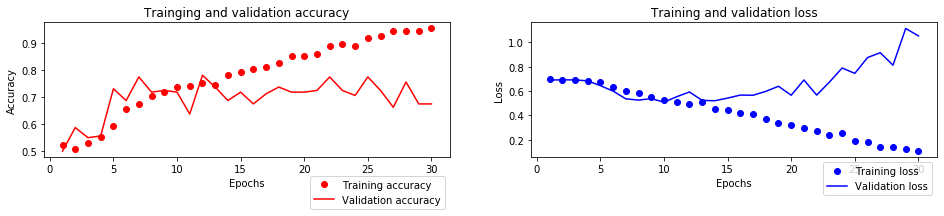

In [35]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
    plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(history.history)

예측: 개
정답: 개


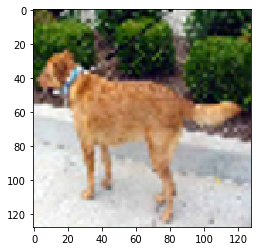

In [38]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

cls_index = ['고양이', '개']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

예측: 고양이
정답: 고양이


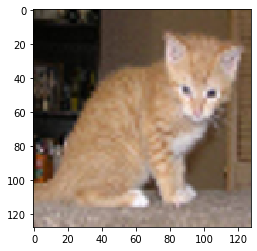

In [39]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

cls_index = ['고양이', '개']

imgs = testGen.next() 
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

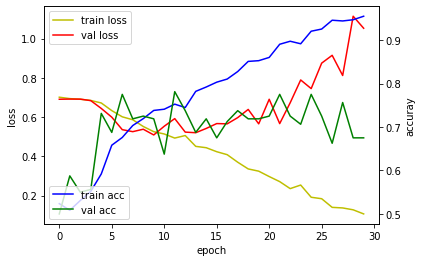

In [41]:

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()